# LIBRARIES

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.geocoders import Bing, Nominatim

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

import pickle

# DataFrame

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/sb_ml_final/JP_Notebook/data/ga_sessions.csv',
                          dtype={'client_id':'O'})

# Data Preparation

In [ ]:
def data_preparation(data):
    df = pd.read_csv('/content/drive/MyDrive/sb_ml_final/JP_Notebook/data/ga_hits.csv',
                      usecols=['session_id', 'event_action'],
                      dtype={'event_action': 'category'})

    # Целевое действие это — события типа «Оставить заявку» и «Заказать звонок»,
    # то есть ga_hits.event_action из event
    event = ['sub_car_claim_click', 'sub_car_claim_submit_click',
            'sub_open_dialog_click', 'sub_custom_question_submit_click',
            'sub_call_number_click', 'sub_callback_submit_click',
            'sub_submit_success', 'sub_car_request_submit_click']

    # Создадим новый столбец, который будет показывать
    # 1 - клиент совершил действие из таблицы event, 0 - нет
    df['target_action'] = df.event_action.apply(lambda x: 1 if x in event else 0).astype('bool')

    # Сделаем сводную таблицу, которая показывает совершил
    # ли пользователь целевое действие хотя бы один раз в рамках одного визита.

    # Данные из ID сессии и совершения целевого действия
    df = pd.pivot_table(df[['session_id', 'target_action']],
                            values='target_action',
                            index='session_id',
                            aggfunc=lambda x: any(x)).astype('bool')
    # Оператор any() возвращает значение True, если хотя бы одно значение в группе равно True.

    # Изменим название столбца сводной таблицы на target
    df.columns = ['target']

    # Надо объединить data и ga_hits, чтобы понять какой ID совершал целевое действие
    data = pd.merge(data, df, on='session_id')

    return data

In [ ]:
data = data_preparation(data)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1732266 entries, 0 to 1732265
Data columns (total 19 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
 18  target                    bool  
dtypes: bool(1), int64(1), object(17)
memory usage: 252.8+ MB


In [ ]:
data.to_pickle('/content/drive/MyDrive/sb_ml_final/data/model/train/data.pickle')

# DataCleaning

In [ ]:
def filter_data(data):
    columns_to_drop = ['session_id', 'client_id', 'visit_date', 'visit_time',
                    'visit_number', 'utm_keyword', 'device_model']

    data.drop(columns_to_drop, axis=1, inplace=True)
    data.drop_duplicates(inplace=True)

    return data

filter_data(data)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365526 entries, 0 to 1732260
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   utm_source                365487 non-null  object
 1   utm_medium                365526 non-null  object
 2   utm_campaign              335029 non-null  object
 3   utm_adcontent             307363 non-null  object
 4   device_category           365526 non-null  object
 5   device_os                 157361 non-null  object
 6   device_brand              286809 non-null  object
 7   device_screen_resolution  365526 non-null  object
 8   device_browser            365526 non-null  object
 9   geo_country               365526 non-null  object
 10  geo_city                  365526 non-null  object
 11  target                    365526 non-null  bool  
dtypes: bool(1), object(11)
memory usage: 33.8+ MB


## MSNO

utm_medium                       0
device_category                  0
device_screen_resolution         0
device_browser                   0
geo_country                      0
geo_city                         0
target                           0
utm_source                      39
utm_campaign                 30497
utm_adcontent                58163
device_brand                 78717
device_os                   208165
dtype: int64


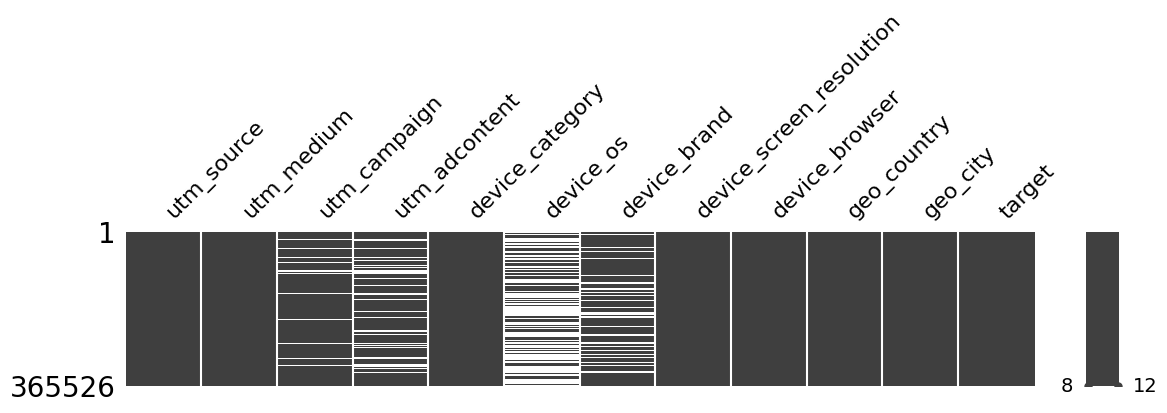

In [ ]:
def data_info(df):
    msno.matrix(df, figsize = (13,2))
    print(df.isnull().sum().sort_values())

data_info(data)

## Fillna

### UTM

In [ ]:
# Так как непонятно от чего зависит utm_adcontent, utm_source и utm_campaign,
# то заменим пустые значения самыми популярным значением и сразу помменяем тип данных

data[['utm_source', 'utm_adcontent', 'utm_campaign']] = data[['utm_source', 'utm_adcontent', 'utm_campaign']].fillna(data.mode().iloc[0])
data = data.astype({
    'utm_source':'category',
    'utm_adcontent':'category',
    'utm_campaign':'category'
    })

### device_brand

In [ ]:
# Выведем информацию по датасету с пустой колонкой device_brand
data[data.device_brand.isna()].describe(include='all')

,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
count,78717,78717,78717,78717,78717,28918,0,78717,78717,78717,78717,78717
unique,229,47,343,255,3,5,0,1699,31,125,1348,2
top,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,NaN,1920x1080,Chrome,Russia,Moscow,False
freq,15764,22457,36577,55282,78432,21015,NaN,16287,37743,70461,15296,73539


In [ ]:
# Функция для создания круговых диаграмм
def create_pie_chart(data_column, chart_title, ax):
    data_counts = data_column.value_counts().head()
    ax.pie(data_counts.values, labels=data_counts.index)
    ax.set_title(chart_title)

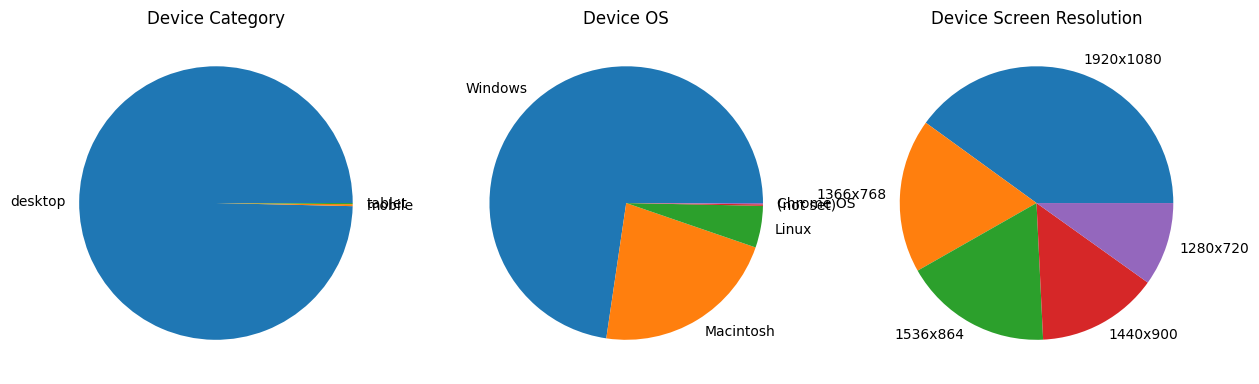

In [ ]:
# По круговым диаграммам попробуем понять какие характеристики у устройств,
# где неизвестен бренд

df = data[data.device_brand.isna()]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

create_pie_chart(df.device_category, 'Device Category', axs[0])
create_pie_chart(df.device_os, 'Device OS', axs[1])
create_pie_chart(df.device_screen_resolution, 'Device Screen Resolution', axs[2])

plt.show()

In [ ]:
# Бренд неизвестен, потому что пользователь сидит с ПК,
# так как device_category desktop, OS Windows, а разрешения экрана -
# размеры мониторов, поэтому заполним пустые значения новым значением: 'PC'

data.device_brand.fillna('PC', inplace=True)
data.device_brand = data.device_brand.astype('category')

### device_os

In [ ]:
data[data.device_os.isna()].head()

,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
3,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,NOBKLgtuvqYWkXQHeYWM,mobile,NaN,Xiaomi,393x786,Chrome,Russia,Moscow,False
4,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Xiaomi,393x786,Chrome,Russia,Moscow,False
5,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Apple,375x812,Safari,Russia,Saint Petersburg,False
7,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Samsung,360x640,Chrome,Russia,Saint Petersburg,False
9,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Samsung,412x915,Chrome,Russia,Moscow,False


In [ ]:
data[(data.device_brand == 'Apple')].device_os.value_counts()

iOS    23617
Name: device_os, dtype: int64

In [ ]:
# У всех устройств бренда 'Apple операционка 'iOS',
# поэтому пустые значения заменим на это значение

data.loc[(data.device_brand == 'Apple') & (data.device_os.isna()), 'device_os'] = 'iOS'

In [ ]:
data[(data.device_brand == 'Apple')].device_os.value_counts()

iOS    59099
Name: device_os, dtype: int64

In [ ]:
data[(data.device_category == 'desktop')].device_os.value_counts()
# Частая ОС десктопов - windows, заполним пустые значения

Windows      21001
Macintosh     6368
Linux         1398
(not set)       53
iOS             48
Chrome OS       42
Android         18
Tizen            2
Name: device_os, dtype: int64

In [ ]:
data.loc[(data.device_category == 'desktop') & (data.device_os.isna()), 'device_os'] = 'Windows'

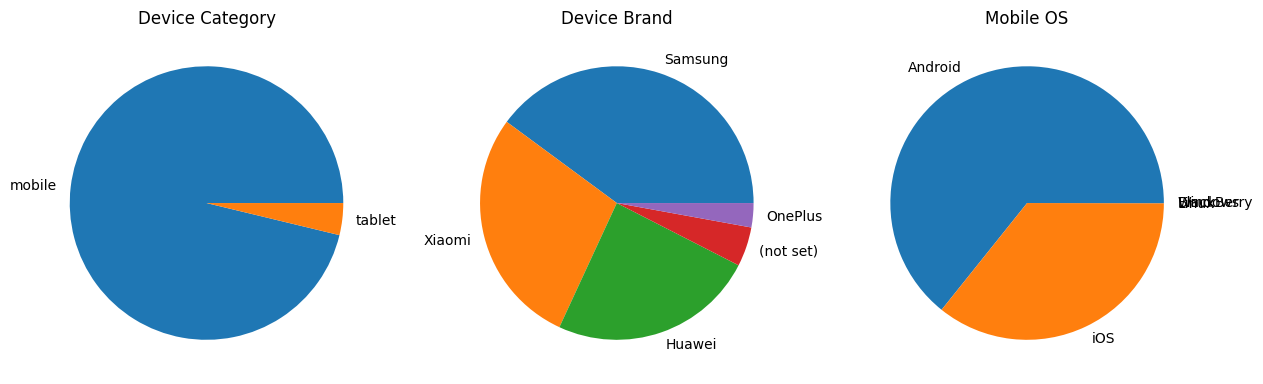

In [ ]:
# По круговым диаграммам попробуем понять какие характеристики у устройств,
# где пропущена ОС

df = data[data.device_os.isna()]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

create_pie_chart(df.device_category, 'Device Category', axs[0])
create_pie_chart(df.device_brand, 'Device Brand', axs[1])
# Самая используемая ОС на телефонах
create_pie_chart(data[data.device_category=='mobile'].device_os, 'Mobile OS', axs[2])

plt.show()

In [ ]:
# оставшиеся устройства это телефоны брендов Samsung, Xiaomi, Huawei и т.д.

# Самая используемая ОС на телефонах - Android
data.device_os.fillna('Android', inplace=True)
data.device_os = data.device_os.astype('category')

## Data save

In [ ]:
# Перед сохранением нужно типизировать оставшиеся категориальные колонки.

for col in data.dtypes[data.dtypes == 'O'].index:
    data[col] = data[col].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365526 entries, 0 to 1732260
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   utm_source                365526 non-null  category
 1   utm_medium                365526 non-null  category
 2   utm_campaign              365526 non-null  category
 3   utm_adcontent             365526 non-null  category
 4   device_category           365526 non-null  category
 5   device_os                 365526 non-null  category
 6   device_brand              365526 non-null  category
 7   device_screen_resolution  365526 non-null  category
 8   device_browser            365526 non-null  category
 9   geo_country               365526 non-null  category
 10  geo_city                  365526 non-null  category
 11  target                    365526 non-null  bool    
dtypes: bool(1), category(11)
memory usage: 9.7 MB


In [ ]:
data.to_pickle('/content/drive/MyDrive/sb_ml_final/JP_Notebook/data/data_clear.pickle')

# Feature Engineering

## New features

In [ ]:
# Добавляем фичу "is_social" – Реклама в соцсетях — визиты с utm_source из socials
socials = ['QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs',
           'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm']
# Если из socials = 1, остальное = 0
data['is_social'] = data.utm_source.apply(lambda x: 1 if x in socials else 0).astype(bool)
data.drop('utm_source', axis=1, inplace=True)


# Добавляем фичу "is_organic" – числовое значение трафика
# Платный трафик — весь неорганический трафик, органический трафик — визиты с utm_medium из
organic_traffic = ['organic', 'referral', '(none)']
# Органический трафик = 1, неорганический = 0
data['is_organic'] = data.utm_medium.apply(lambda x: 1 if x in organic_traffic else 0).astype(bool)
data.drop('utm_medium', axis=1, inplace=True)


# Добавляем фичу "device_screenx" и "device_screeny" – числовое значение разрешения экрана
data[['device_screenx', 'device_screeny']] = data.device_screen_resolution.str.split('x', expand=True).astype('int16')
data.drop('device_screen_resolution', axis=1, inplace=True)

In [ ]:
# Возьмем индексы строк, где target = True и строки, где target = False,
# создадим и сохраним новый сбалансированный датасет

def balancing(df):
    data = df.copy()
    true_id = list(data.drop_duplicates()[data.target == True].index)
    false_id = list(data.drop_duplicates()[data.target == False].index)[:len(true_id)]

    data = data.loc[true_id+false_id]

    balanced_df = pd.read_pickle('/content/drive/MyDrive/sb_ml_final/data/model/train/data.pickle')
    balanced_df = balanced_df.iloc[true_id+false_id]
    balanced_df.to_pickle('/content/drive/MyDrive/sb_ml_final/data/model/train/balanced_df.pickle')

    return data

data = balancing(data)

<ipython-input-27-6e9275d9fa91>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  true_id = list(data.drop_duplicates()[data.target == True].index)
<ipython-input-27-6e9275d9fa91>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  false_id = list(data.drop_duplicates()[data.target == False].index)[:len(true_id)]


In [ ]:
# Добавляем фичу 'is_represented'

# Для геокодирования уникальных городов используется библиотека geopy и
# сервисы - Bing и Nominatim.
# Результаты геокодирования сохраняются в словаре city_latlon, где ключами
# являются названия городов, а значениями - словарь с ключом 'is_represented'
# Производится попытка сначала использовать сервис Bing, а затем - Nominatim.
# Если ни один из сервисов не вернул результат, то для города будет значение False.
# Обработка ошибок выполняется при помощи исключений и Exception.

# Импортируем исключения для обработки запросов на геопозиционирование.
from geopy.exc import GeocoderServiceError, GeocoderTimedOut, GeocoderUnavailable

def geocoding(df):
    data = df.copy()

    key = 'ApV08qhNNtqzPiYatKo1fXktsXuf2B6Xh7s9_GpvqsaWloZfxeaBhyvrHdZ745ZI'

    geoBing = Bing(api_key=key)
    geoNomin = Nominatim(user_agent="my_app")
    city_latlon = dict()

    for city in data['geo_city'].unique():
        try:
            location = geoBing.geocode(city, timeout=10)
            if location:
                try:
                    if location.raw['address']['adminDistrict'] in ['Moscow City', 'Moscow', 'Leningrad', 'St Petersburg City']:
                        city_latlon[city] = {'is_represented':True}
                    else:
                        city_latlon[city] = {'is_represented':False}
                except:
                    city_latlon[city] = {'is_represented':False}
            else:
                location = geoNomin.geocode(city, timeout=10)
                if location:
                    res = any(item in (location.raw['display_name'].split(', ')) for item in ['Московская область', 'Ленинградская область', 'Москва', 'Санкт-Петербург'])
                    if res:
                        city_latlon[city] = {'is_represented':True}
                    else:
                        city_latlon[city] = {'is_represented':False}
        except (GeocoderServiceError, GeocoderTimedOut) as e:
            print(f"Geocoder service error occurred while geocoding {city}: {e}")
            city_latlon[city] = {'is_represented':False}
        except (GeocoderUnavailable) as e:
            print(f'Geocoder unavailable. Geocoding {city}, error: {e}')
            break
        except Exception as e:
            print(f"Error while geocoding {city}: {e}")
            city_latlon[city] = {'is_represented':False}

    city_latlon = pd.DataFrame.from_dict(city_latlon, orient='index').reset_index()
    city_latlon = city_latlon.rename({'index': 'geo_city'}, axis=1)

    data = pd.merge(data, city_latlon, on='geo_city', how='left')
    data = data.drop('geo_city', axis=1)
    data.is_represented = data.is_represented.astype(bool)

    return data

In [ ]:
data = geocoding(data)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37262 entries, 0 to 37261
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   utm_campaign     37262 non-null  category
 1   utm_adcontent    37262 non-null  category
 2   device_category  37262 non-null  category
 3   device_os        37262 non-null  category
 4   device_brand     37262 non-null  category
 5   device_browser   37262 non-null  category
 6   geo_country      37262 non-null  category
 7   target           37262 non-null  bool    
 8   is_social        37262 non-null  bool    
 9   is_organic       37262 non-null  bool    
 10  device_screenx   37262 non-null  int16   
 11  device_screeny   37262 non-null  int16   
 12  is_represented   37262 non-null  bool    
dtypes: bool(4), category(7), int16(2)
memory usage: 1.0 MB


## Data Save

In [ ]:
# Перед кодированием переменных нужно удалить дубликаты, которые
# появились при очистке и добавлении новых фич
data.drop_duplicates(inplace=True)

data.to_pickle('/content/drive/MyDrive/sb_ml_final/JP_Notebook/data/data_clear_tocode.pickle')

## Кодирование переменных

In [ ]:
# # Кодируем категориальные фичи с помощью OneHotEncoder

categs = data.dtypes[data.dtypes == 'category'].index
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=bool)

data.loc[:, ohe.get_feature_names_out()] = ohe.fit_transform(data[categs])

In [ ]:
# Масштабируем числовые фичи
vars = ['device_screenx', 'device_screeny']
vars_std = list(map(lambda x: x + '_std', vars))

std_scaler = StandardScaler()

data.loc[:, vars_std] = std_scaler.fit_transform(data[vars])

## Корелляция


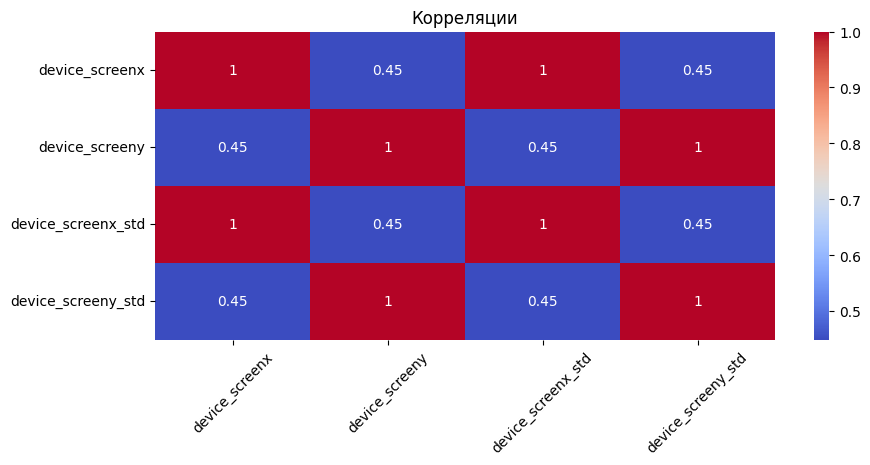

In [ ]:
# Настройка размера области построения
plt.figure(figsize=(10,4))
# Построение хитмапа
sns.heatmap(data[vars+vars_std].corr(), annot=True, cmap='coolwarm')

# Настройка осей координат и заголовка
plt.title('Корреляции')
plt.xticks(rotation=45)

# Отображение графика
plt.show()

Существует умеренная положительная корреляция (0.45) между device_screenx и device_screeny.

# Финальный датасет

In [ ]:
data.drop(list(categs)+vars, axis=1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19266 entries, 0 to 37261
Columns: 635 entries, target to device_screeny_std
dtypes: bool(633), float64(2)
memory usage: 12.1 MB


In [ ]:
data.to_pickle('/content/drive/MyDrive/sb_ml_final/JP_Notebook/data/new_data_to_learning.pickle')

# Моделирование

model: LogisticRegression, roc_auc: 65.4322, roc_std: 0.0011


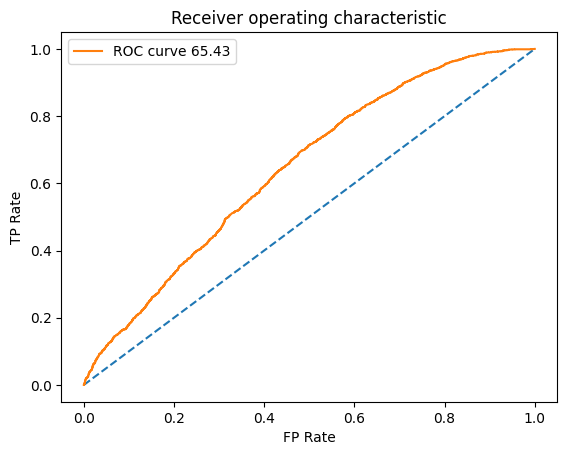

model: MLPClassifier, roc_auc: 65.2159, roc_std: 0.0019


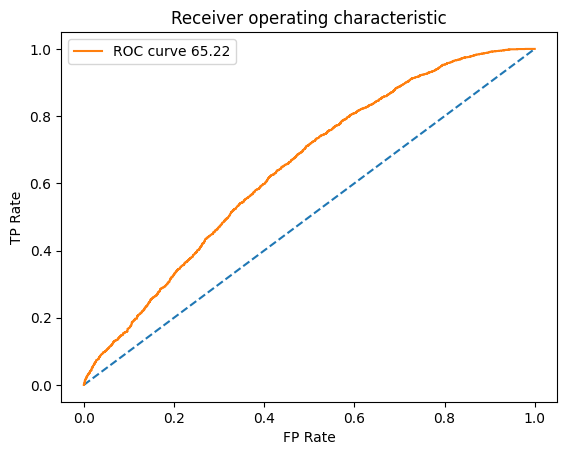

model: RandomForestClassifier, roc_auc: 64.2081, roc_std: 0.0051


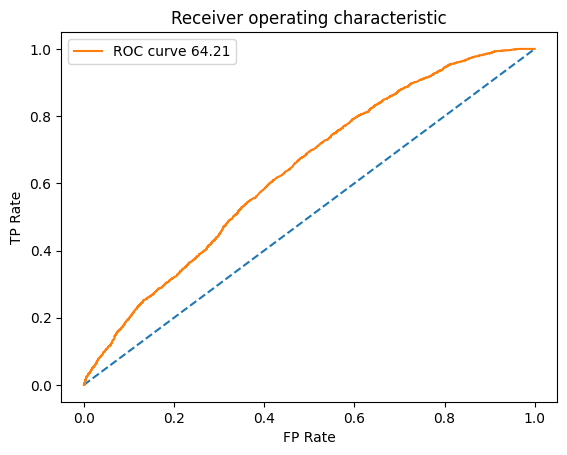

best model: LogisticRegression, roc_auc: 0.6543


In [ ]:
def predict(df):
    features_df = df.copy()
    X = features_df.drop(['target'], axis=1)
    y = features_df['target']

    # Определение моделей для обучения
    models = [
            LogisticRegression(C=0.64, random_state=1, solver='newton-cholesky', tol=0.06),  # roc_auc: 65.4322, time: 0:00:02.777847
            MLPClassifier(activation='logistic', alpha=0.02, batch_size=50, epsilon=0.002, random_state=10),  # roc_auc: 65.2159, time: 0:08:32.883863
            RandomForestClassifier(max_depth=10, max_features=104, min_samples_leaf=13,random_state=42),  # roc_auc: 64.2081, time: 0:00:20.021023
    ]

    best_score = .0
    best = None

    for model in models:

        # Оценка качества модели с помощью кросс-валидации
        score = cross_val_score(model, X, y, cv=4, scoring='roc_auc')

        print(f'model: {type(model).__name__}, roc_auc: {score.mean()*100:.4f}, roc_std: {score.std():.4f}')

        # Разделение данных на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

        # Обучение модели на обучающей выборке
        model.fit(X_train, y_train)

        # Предсказание вероятностей на тестовой выборке
        pred = model.predict_proba(X_test)[:, 1]
        # Рассчитывание AUC-ROC и построение ROC-кривой
        fpr, tpr, _ = roc_curve(y_test, pred)

        # Визуализация ROC-кривой
        plt.figure()
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(fpr, tpr, label=f'ROC curve {score.mean()*100:.2f}')
        plt.xlabel('FP Rate')
        plt.ylabel('TP Rate')
        plt.title('Receiver operating characteristic')
        plt.legend()
        plt.show()

        if score.mean() > best_score:
            best_score = score.mean()
            best = model

    print(f'best model: {type(best).__name__}, roc_auc: {best_score:.4f}')

    return best

best_model = predict(data)

# RESULTS

Лучше всего себя показала модель RandomForestClassifier.

In [ ]:
X = data.drop(['target'], axis=1)
y = data['target']

best_model = best_model.fit(X, y)

filename = '/content/drive/MyDrive/sb_ml_final/JP_Notebook/sub_predict_model.pickle'

with open(filename, 'wb') as file:
    pickle.dump(best_model, file)